In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [2]:
survey_results_public = pd.read_csv('../soverflow/survey_results_public.csv')
survey_results_schema = pd.read_csv('../soverflow/survey_results_schema.csv')

---
# Business questions

My goal with this data is to get a better understanding of who to hire if I'm looking for programmers. Hiring the correct programmers is a critical business problem for several reasons. First of all, the difference between good and mediocre programmers is large compared to most other roles. Secondly, that difference does not have a 1-to-1 correlation with salary. As a result, it's often better to pay a high salary for 1 developer instead of the same total for 2 or more developers.

There are a lot of factors to consider, but in this analysis, I look at binary factors where both options have many samples. My three business questions are: 

## Question 1: Can I hire people without a Computer Science education?
Is it important that programmers have a related education or are there other more important factors that I should consider when hiring?

## Question 2: Should open-source contribution be a requirement?
Contribution to open-source could be a good indication if someone is a skilled developer. Should this be an early requirement if we want to find the best programmers?

## Question 3: Tabs or Spaces?
Could something as simple as if a person uses tabs or spaces in their code be a factor in the hiring process?

---
# Data Preparation & Assumptions

It's not obvious how to use this data to answer questions about who to hire. I'll make the assumption than good develoopers make more money than mediocre developers. Based on that assumption, I'll create a subset of the full-time developers that shared their salary. To make salary consistent, I focus on developers in the US.

In [3]:
full_time = survey_results_public[~survey_results_public.Salary.isnull()]
full_time = full_time[full_time.EmploymentStatus == 'Employed full-time']
full_time = full_time[full_time.Country == 'United States']
full_time = full_time[full_time.University == 'No']

My dataset contains `3722` entries which is enough to look at my questions. However, if we want to have a better answer, it would be a good idea to download data from additional years. As a first step, I want to look at the Salary distribution to see if I need to remove any outliers.

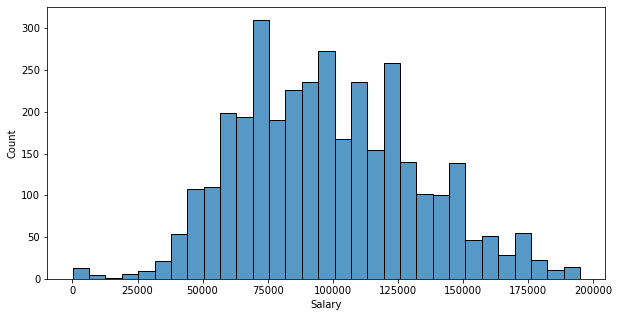

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(full_time.Salary)
plt.show()

It's clear that there are some outliers on the left side since some people make almost 0$ a year sound strange. There are many ways to deal with outliers for this project, but I'll just remove the top 1% and bottom 1%.

In [5]:
top_one_percent = np.percentile(full_time.Salary, 99)
bottom_one_percent = np.percentile(full_time.Salary, 1)

full_time = full_time[full_time.Salary > bottom_one_percent]
full_time = full_time[full_time.Salary < top_one_percent]

## Helper functions

In [6]:
def plot_and_validate(s1, s1_title, s2, s2_title):
    """
    This function compares to distributions.
    It creates a visual plot, writes the average, and performs a T-test.
    
    inputs:
      s1: The first salary distribution
      s1_title: The title for the first distribution
      s2: The second salary distribution
      s2_title: The title for the second distribution
      
    outputs: None
    """
    n_samples = min([len(s1), len(s2)])
    s1 = np.random.choice(s1, n_samples, replace=False)
    s2 = np.random.choice(s2, n_samples, replace=False)
    
    # Create plot
    plt.figure(figsize=(13, 5))
    sns.kdeplot(s1, shade=True, label=s1_title)
    sns.kdeplot(s2, shade=True, label=s2_title)
    plt.yticks([])
    plt.ylabel('')
    plt.legend()
    plt.show()
    
    # T-test
    p_value = ttest_ind(
        np.random.choice(s1, n_samples, replace=False),
        np.random.choice(s2, n_samples, replace=False),
    ).pvalue
    
    print('The average difference in salaries are: {}'.format(round(abs(s1.mean() - s2.mean()), 0)))
    print('The p-value is: {}'.format(round(p_value, 4)))

---
# Q1: Can I hire people without a Computer Science education?

To answer this question we look at the answers on "Which of the following best describes your main field of study (aka 'major') in college or university/for your undergraduate studies?". One of the answers are "Computer science or software engineering". 

In [7]:
full_time['DidStudyCS'] = full_time.MajorUndergrad == 'Computer science or software engineering'

computer_science = full_time[full_time.DidStudyCS == True]
other_education = full_time[full_time.DidStudyCS == False]

To test if the difference in statistics is statistically significant, we perform a T-test. If the p-value is less than 0.05 we conclude that there's a statistically significant difference between the two distributions.

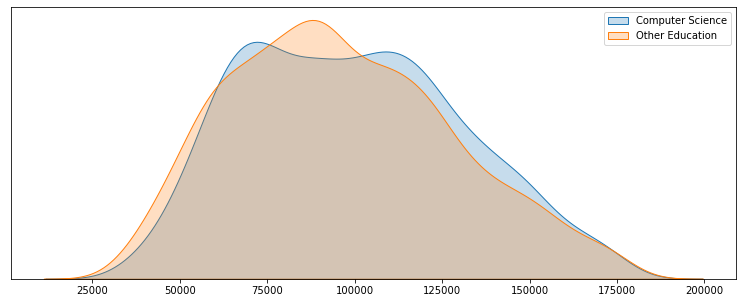

The average difference in salaries are: 3151.0
The p-value is: 0.0044


In [8]:
plot_and_validate(
    computer_science.Salary, 'Computer Science',
    other_education.Salary, 'Other Education'
)

We can see that there's an average difference of around 2725$ in annual salary between the two distributions. According to the T-test this difference is statistcally significant, but not with a lot. We can also see on the plot that the differnce between the distributions is small. To me it seems from this shallow analysis that you don't need an education in computer science or software engineering to become a good programmer.

---
# Q2: Should open-source contribution be a requirement?

Next we want to test if contribution to open-source projects is a good indicator if a person is hireable. Below are the possible answers to the relevant question. I consider "Yes, both" and "Yes, I contribute to open source projects" as `True` and everything else as `False`.

In [9]:
full_time['ProgramHobby']. value_counts()

Yes, I program as a hobby                    1616
Yes, both                                     986
No                                            643
Yes, I contribute to open source projects     153
Name: ProgramHobby, dtype: int64

In [10]:
os_values = ['Yes, both', 'Yes, I contribute to open source projects']
full_time['ContributesToOpenSource'] = full_time.ProgramHobby.isin(os_values)

is_contributor = full_time[full_time.ContributesToOpenSource == True]
is_not_contributor = full_time[full_time.ContributesToOpenSource == False]

No we plot the results and perform the same tests as before

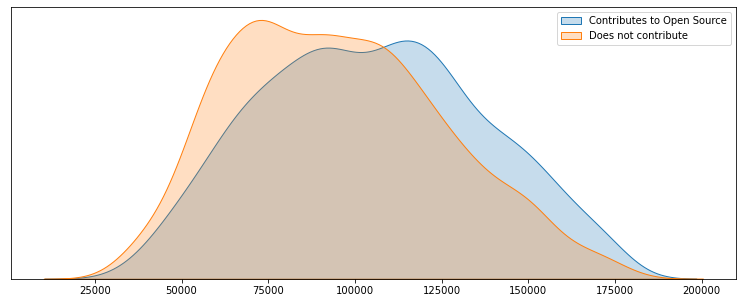

The average difference in salaries are: 10098.0
The p-value is: 0.0


In [11]:
plot_and_validate(
    is_contributor.Salary, 'Contributes to Open Source',
    is_not_contributor.Salary, 'Does not contribute'
)

Here, we see a very clear difference in salary between people who contributes to open source to those that doesn't. The average difference is over 10,000 in annual salary and the p-value is 0. If salary is an indication of skills, we should definitly hire developers who contributes to open-source projects.

---
# Q3: Tabs or Spaces?

There's a bit of a debate within the developer community about using space or tabs for indenting code. Most experienced programmers would say that space is the correct answer because it's more consistent and makes formatting easier. Let's see if this is something we should consider when hiring someone.

In [12]:
full_time['TabsSpaces']. value_counts()

Spaces    1651
Tabs      1206
Both       454
Name: TabsSpaces, dtype: int64

In [13]:
full_time['OnlySpaces'] = full_time.TabsSpaces == 'Spaces'

only_spaces = full_time[full_time.OnlySpaces == True]
uses_tabs = full_time[full_time.OnlySpaces == False]

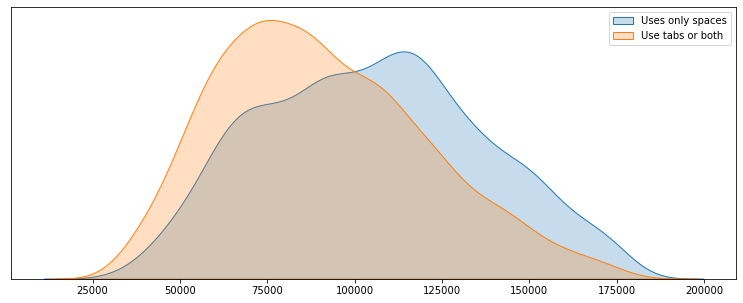

The average difference in salaries are: 14523.0
The p-value is: 0.0


In [14]:
plot_and_validate(
    only_spaces.Salary, 'Uses only spaces',
    uses_tabs.Salary, 'Use tabs or both'
)

Here we see the clearest difference in salaries so far. Programmers who only uses space earn on average 14,200$ more per year compared to people who use tabs or both. The P-value is 0 which means that this difference is significant.

Now it's possible that this answer have a high correlation to experience. Let's make a couple of tests for different levels of experience to see if this answer is relevant or if it's just a proxy for experience

In [15]:
full_time = full_time[full_time.YearsCodedJob != 'Less than a year']
full_time = full_time[~full_time.YearsCodedJob.isnull()]
full_time.YearsCodedJob = full_time.YearsCodedJob.str.split().str[0].astype(int)

## Programming for more than 10 years

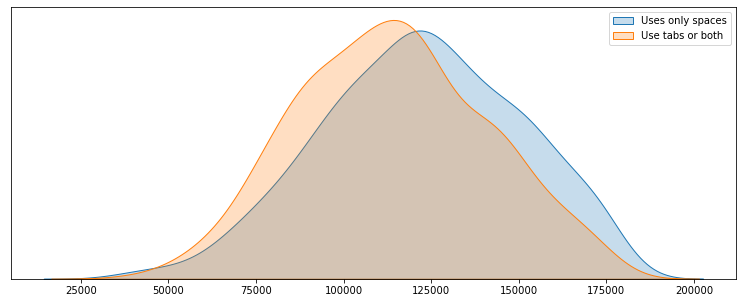

The average difference in salaries are: 8397.0
The p-value is: 0.0


In [16]:
more_than_ten = full_time[full_time.YearsCodedJob > 10]
only_spaces = more_than_ten[more_than_ten.OnlySpaces == True]
uses_tabs = more_than_ten[more_than_ten.OnlySpaces == False]

plot_and_validate(
    only_spaces.Salary, 'Uses only spaces',
    uses_tabs.Salary, 'Use tabs or both'
)

For programmers with more than 10 years of experience, we still se a statistically significant difference between tabs and spaces. The difference is smaller, but it's still above 8,000$ a year.

## Programming for less than 5 years

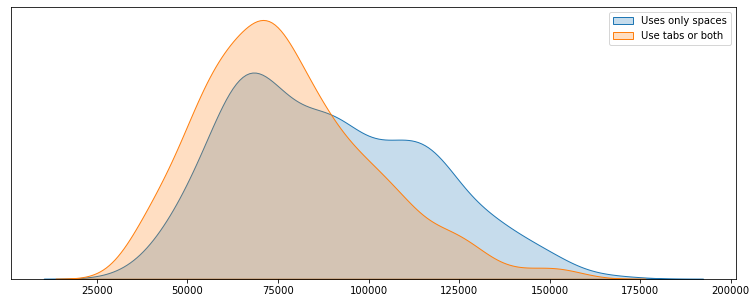

The average difference in salaries are: 11679.0
The p-value is: 0.0


In [17]:
more_than_ten = full_time[full_time.YearsCodedJob <= 5]
only_spaces = more_than_ten[more_than_ten.OnlySpaces == True]
uses_tabs = more_than_ten[more_than_ten.OnlySpaces == False]

plot_and_validate(
    only_spaces.Salary, 'Uses only spaces',
    uses_tabs.Salary, 'Use tabs or both'
)

The difference is still there when we look at programmers with less than five years of experience. 

---

# Conclusions

It's clear that factors such as tabs or spaces have a clear correlation to salary. If salary has a correlation to skills, this kind of simple questions are critical to ask during a reqruitment-process. It could also provide essential information for training programs and in-house education.